In [1]:
from numpy.random import randint
from numpy.random import rand
import numpy as np
import random
import math
import time
import string

In [2]:
# fitness function (given solution={'suppliers','profit','client'})
def fitness(components, clients, sol):
  
  qualityPerceptions = []
  desirabilities = []
  sales = []
  totalSales = 0
  z = 0

  for cliIdx, client in enumerate(clients):

    # client info
    wQ = client["wQ"]
    wP = client["wP"]
    mktShare = client["mktShare"]

    # price
    totalCost = 0
    for compIdx, supIdx in enumerate(sol["suppliers"]):
      supplier = components[compIdx]["suppliers"][supIdx]
      totalCost += supplier[1]
    totalPrice = totalCost + sol["profit"]
    normalizedPrice = (totalPrice - minMktPrice) / (maxMktPrice - minMktPrice)

    # quality
    qualityPerception = 0
    for compIdx, supIdx in enumerate(sol["suppliers"]):
      supplier = components[compIdx]["suppliers"][supIdx]
      qualityPerception += supplier[0] * components[compIdx]["clients"][cliIdx]
    # qualityPerception = qualityPerception / len(components) # no es necesario dado que los pesos de calidad a cada componente suman 1

    # total
    factor = 1 / (wQ + wP)

    if normalizedPrice <= 1.0:
      desirability = wQ * factor * qualityPerception + wP * factor * (1 - normalizedPrice)
    else:
      desirability = 0 # penalty for abusive prices (beyond max market price)

    clientSales = desirability * mktShare

    qualityPerceptions.append(qualityPerception)
    desirabilities.append(desirability)
    sales.append(clientSales)

    if clientSales > 0:     
      totalSales += clientSales
  
  # add a profit to each sale
  z = totalSales * sol["profit"]
    
  return {
      "cost":totalCost,
      "price":totalPrice,
      "normprice":normalizedPrice,
      "qperceptions":qualityPerceptions,
      "desirabilities":desirabilities,
      "sales":sales,
      "totalsales":totalSales,
      "profit":sol["profit"],
      "score":z
  }

# initialize solution
def solution(components, clients, suppliers=None, profit=None):

  if suppliers is None:
    suppliers=[]
    for comp in components:
      suppliers.append(random.randint(0,len(comp["suppliers"])-1))
  
  if profit is None:
    profit=random.randint(10,10000)

  s = {
       "suppliers":suppliers,
       "profit":profit
  }

  valid, msg = validSolution(components, clients, s)

  if valid:
    return s
  else:
    print(msg)
    return None

# fix feasibility constraints
def fix(sol):
  if sol["profit"] < 0: sol["profit"] = 0

# tournament selection
def selection(sortedPop, k=3):
  competitors=[]
  for i in range(k-1):
    s = sortedPop[random.randint(0,len(sortedPop)-1)]
    competitors.append(s)
  return max(competitors,key=lambda k: k['results']['score'])
 
# crossover two parents to create two children
def crossover(components, parent1, parent2, r_cross):
	# children are copies of parents by default
  child1, child2 = parent1.copy(), parent2.copy()
  # mix suppliers
  swapPt=random.randint(0,len(components)-1)
  if rand() < r_cross:
    child1["suppliers"] = parent1["suppliers"][:swapPt] + parent2["suppliers"][swapPt:]
    child2["suppliers"] = parent2["suppliers"][:swapPt] + parent1["suppliers"][swapPt:]
	# mix profit
  avgProfit = (parent1["profit"] + parent2["profit"]) / 2.0
  if rand() < r_cross:
    child1["profit"] = avgProfit
  if rand() < r_cross:
    child2["profit"] = avgProfit

  return [child1, child2]
 
# mutation operator
def mutation(components, clients, solution, r_mut):
  for compIdx, supIdx in enumerate(solution["suppliers"]):
    # mutate supplier
    if rand() < r_mut:
      randSup = random.randint(0,len(components[compIdx]["suppliers"])-1)
      solution["suppliers"][compIdx] = randSup
    # mutate profit
    if rand() < r_mut:
      solution["profit"] += random.uniform(maxProfitDrop,maxProfitIncrease)

# replace operator
def replace(sortedPop, children):
  replacedPop = []
  # worst solutions are replaced by children
  if len(children) >= len(sortedPop):
    print('WARNING! Population is fully replaced by children. No parents left')
    replacedPop = children.copy()
  else:
    parents = sortedPop[:len(sortedPop) - len(children)]
    replacedPop = parents + children
    if len(replacedPop) != len(sortedPop):
      print('WARNING! Population size changed after replacement from ' + str(len(sortedPop)) + ' to ' + str(len(replacedPop)) + '!')
  return replacedPop

# genetic algorithm
def genetic_algorithm(components, clients, n_iter, n_convg, n_pop, k_tnmt, r_sel, r_cross, r_mut):
	# initial population of random bitstring
  pop = [solution(components, clients) for _ in range(n_pop)]
  # fix and evaluate all candidates in the population
  for sol in pop:
    fix(sol)
    sol["results"] = fitness(components, clients, sol)
  # sort population by score (pop[0] will have highest score)
  pop = sorted(pop, key=lambda k: k['results']['score'], reverse=True)
	# init output
  bestScore = pop[0]['results']['score']
  history = []
  convgCount=0
  # enumerate generations
  for gen in range(n_iter):

		# All solutions have been previously evaluated and sorted by score (before generation 0 or at the end of generation n-1)
    startTime = time.time()
    totalEvaluations=0
    # select parents
    parentsCount = math.floor(len(pop)*r_sel)
    selected = []
    for i in range(parentsCount):
      selected.append(selection(pop, k_tnmt))
    # create the next generation
    children = []
    for i in range(0, len(selected)-1, 2):
      # get selected parents in pairs
      p1, p2 = selected[i], selected[i+1]
      # crossover and mutation
      for child in crossover(components, p1, p2, r_cross):
        # mutation
        mutation(components, clients, child, r_mut)
        # fix children
        fix(child)
        # find fitness of children
        child['results'] = fitness(components, clients, child)
        totalEvaluations += 1
        # store for next generation
        children.append(child)  
    # sort population by score (pop[0] will have highest score)
    pop = sorted(pop, key=lambda k: k['results']['score'], reverse=True)
    # replace population 
    pop = replace(pop, children)
    # check for new best solution
    tmpBestScore = pop[0]['results']['score']
    if tmpBestScore > bestScore:
      bestScore = tmpBestScore
      convgCount = 0
      # print("> New best: " + str(pop[0]))
    elif tmpBestScore == bestScore:
      convgCount += 1
    elif gen > 1 and tmpBestScore < bestScore:
      print('WARNING! Best sol in gen ' + str(gen) + ' (score: ' + str(tmpBestScore) + ') is worse than best sol in gen ' + str(gen-1) + ' (score: ' + str(bestScore)+ ')')
    # update history after updating scores and sorting
    log = {
        "best": pop[0].copy(),
        "timeSpent": time.time() - startTime,
        "totalEvaluations": totalEvaluations
    }
    history.append(log)
    # check for termination condition
    if n_convg > 0 and n_convg == convgCount:
      break

  return pop[0], history

In [3]:
def isNormalized(f):
  # accept some error margin
  return f >= -0.999999 and f <= 1.000001

# validate data
def validData(components, clients):
  for comp in components:
    if len(comp["clients"]) is not len(clients): return False, "Some component has a number of clients not equal to " + str(len(clients))
    for s in comp["suppliers"]:
      if not isNormalized(s[0]): return False, "Some quality value of a supplier of a component is not normalized"
    for c in comp["clients"]:
      if not isNormalized(c): return False, "Some Quality weights of a client of a component is not normalized"
  for cliIdx, cli in enumerate(clients):
    if not isNormalized(cli["wQ"]): return False, "Some client has not normalized wQ"
    if not isNormalized(cli["wP"]): return False, "Some client has not normalized wP"
    if not isNormalized(cli["mktShare"]): return False, "Some client has not normalized mktShare" 
    totalQualityWeightsOfClient = 0
    for comp in components:
      totalQualityWeightsOfClient += comp["clients"][cliIdx]
    if not isNormalized(totalQualityWeightsOfClient): return False, "Total quality weights of client " + str(cliIdx) + " is not normalized (" + str(totalQualityWeightsOfClient) + ")"
    totalMktShare = 0
    for cli in clients:
      totalMktShare += cli["mktShare"]
    if not isNormalized(totalMktShare): return False, "Total market share of clients is not normalized, they don't add up to 1.0"
  return True, "All systems nominal!"

# validate solutions correctness
def validSolution(components, clients, solution):
  if len(solution["suppliers"]) is not len(components): return False, "Solution has incorrect number of suppliers"
  for supIdx,sup in enumerate(solution["suppliers"]):
    if sup < 0 or sup >= len(components[supIdx]["suppliers"]): return False, "Solution has incorrect supplier index at component index " + str(supIdx)
  return True, "Solution looks good!"

In [4]:
# Generated data

def rndClients(clientsCount):
  clients = []
  for c in range(clientsCount):
    client = {
      "name": ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(10)),
      "wQ": round(rand(),3),
      "wP": round(rand(),3),
      "mktShare": round(rand(),3)
    }
    clients.append(client)
  
  # fix client market share
  for c in clients:
    factor = 0
    for cliIdx in range(clientsCount):
      factor += clients[cliIdx]["mktShare"]
    factor = 1 / factor
    for cliIdx in range(clientsCount):
      clients[cliIdx]["mktShare"] *= factor

  return clients

def rndComponents(componentsCount, suppliersCount, minPrice, maxPrice, clientsCount):

  components = []
  for c in range(componentsCount):
    suppliers = []
    for s in range(suppliersCount):
      suppliers.append((round(rand(),3),round(random.uniform(minPrice, maxPrice),2)));
      #suppliers.append((1.0,round(random.uniform(0.0, minPrice),2))); # abnormally low component prices

    clientsQualityWs = []
    for c in range(clientsCount):
      clientsQualityWs.append(round(rand(),3));
      #clientsQualityWs.append(1.0) # equal distribution of market share between clients

    comp = {
        "name": ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(10)),
        "suppliers": suppliers,
        "clients": clientsQualityWs
    }
    components.append(comp)

  # fix client quality weights
  for cliIdx in range(clientsCount):
    factor = 0
    for comp in components:
      factor += comp["clients"][cliIdx]
    factor = 1 / factor
    for comp in components:
      comp["clients"][cliIdx] *= factor

  return components

components=None
clients=None

In [5]:
# generation of different problem sizes

minMktPrice = 300
maxMktPrice = 2700

problemNames = ["compact","-","medium","-","fragmented"]
clientCount = [5,15,25,38,50]
componentCount = [15,48,82,116,150]
supplierCount = [10,32,55,78,100]

problems = []
for i in range(len(problemNames)):

  minCompPrice = minMktPrice/componentCount[i]
  maxCompPrice = maxMktPrice/componentCount[i]

  p = {
    "name":problemNames[i],
    "clients": rndClients(clientCount[i]),
    "components": rndComponents(componentCount[i],supplierCount[i],minCompPrice,maxCompPrice,clientCount[i])
  }
  dataIsValid, m = validData(p['components'], p['clients'])
  if dataIsValid:
    problems.append(p)
    print(f"Problem {p['name']} generated!")
  else:
    print(m)

Problem compact generated!
Problem - generated!
Problem medium generated!
Problem - generated!
Problem fragmented generated!


In [7]:
# profit variability
maxProfitDrop = -1 * (maxMktPrice - minMktPrice) 
maxProfitIncrease = (maxMktPrice - minMktPrice) 

# total iterations
n_iter = 500

# max generations without improvement
n_convg = -1

# population size
# n_pop = 500
X = [10,50,100,500]

# tournament group size
k_tnmt = 3

# selection rate
r_sel = 0.95

# crossover rate
r_cross = 0.95

# mutation rate
r_mut = 0.01

histories =[]
times_spent=[]

prb = problems[2]

if dataIsValid:

  for n_pop in X:
    print('Population size: ' + str(n_pop))
    print('Finding the best individual...')
    # perform the genetic algorithm search
    timeInit = time.time()  
    bestSol, history = genetic_algorithm(prb['components'], prb['clients'], n_iter, n_convg, n_pop, k_tnmt, r_sel, r_cross, r_mut)
    histories.append(history)
    t_s = time.time() - timeInit
    times_spent.append(t_s)
    print('Time spent: ' + str(t_s)) 
    print('Done! Best Z for size ' + str(n_pop) + ': ' + str(bestSol['results']['score']) + '\n')

  # show results
  print("All tests were performed!")

Population size: 10
Finding the best individual...
Time spent: 3.953071355819702
Done! Best Z for size 10: 448.473918487398

Population size: 50
Finding the best individual...
Time spent: 22.297470092773438
Done! Best Z for size 50: 716.0260128807527

Population size: 100
Finding the best individual...
Time spent: 46.044243574142456
Done! Best Z for size 100: 721.6730933319221

Population size: 500
Finding the best individual...
Time spent: 231.20244669914246
Done! Best Z for size 500: 838.9933550158331

All tests were performed!


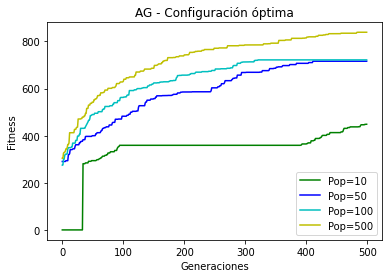

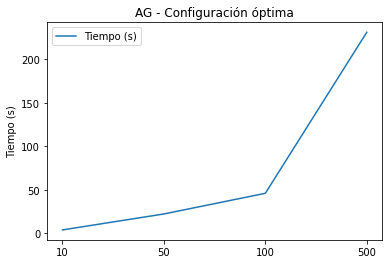

In [8]:
import matplotlib.pyplot as plt

def Next(list, idx):
  if idx >= len(list) - 1:
    return 0
  else:
    return idx+1

colors = ['r','g','b','c','y','b']

# best scores of each generation
value = None
colorIdx = 0
for testIdx, h in enumerate(histories):

  x = range(len(h))
  y = [d['best']['results']['score'] for d in h]


  if value != X[testIdx]:
    value = X[testIdx]
    colorIdx = Next(colors,colorIdx)
    plt.plot(x, y, label=f'Pop={X[testIdx]}', color=colors[colorIdx])
  else:
    plt.plot(x, y, color=colors[colorIdx]) 

plt.xlabel("Generaciones")
plt.ylabel("Fitness")
plt.title("AG - Configuración óptima")
plt.legend()
plt.show()

# time spent

x = range(len(X))
y = times_spent
plt.plot(x, y, label="Tiempo (s)")
plt.xticks(x, X)
plt.ylabel("Tiempo (s)")
plt.title("AG - Configuración óptima")
plt.legend()
plt.show()

In [9]:
# Enfriamiento Simulado
import matplotlib.pyplot as plt

def anneal(current_t, max_t, current_iter, max_iter, cooling):
  newT = max_t * math.pow(math.e,-cooling*(current_iter/max_iter))
  return newT

def simulated_annealing(components, clients, n_iter, n_meta_iter, n_convg, max_t, r_mut, cooling):

  # Valores iniciales
  current_sol=solution(components, clients)
  current_sol['results'] = fitness(components, clients, current_sol)
  best_sol=current_sol.copy()

  for meta_i in range(n_meta_iter):

    history=[]
    fitnessCalls=[]
    convgCount = 0

    # Retroalimentacion
    current_sol=best_sol

    # Reinicio de temperatura
    temperature = max_t   

    # Mientras no se cumpla el criterio de terminacion
    for i in range(n_iter):
      # Nuevo = Mutacion del actual
      new_sol=current_sol.copy()
      mutation(components, clients, new_sol, r_mut * (temperature/max_t))
      # Diferencia del fitness
      new_sol["results"] = fitness(components, clients, new_sol)
      fitnessCalls.append(new_sol["results"].copy())
      deltaF = new_sol["results"]["score"] - current_sol["results"]["score"]
      # Si mejora:
      if deltaF > 0:
        #   Actual = Nuevo
        current_sol=new_sol
        #   Comprueba y actualiza la mejor solucion
        if current_sol['results']['score'] > best_sol['results']['score']:
          best_sol = current_sol.copy()
      # Si no:
      else:
        #   Actual = Nuevo con una probabilidad dependiente de la temperatura
        if rand() < math.pow(math.e,(deltaF/temperature)):
          current_sol = new_sol
        #   Baja la temperatura
        temperature = anneal(temperature, max_t, i, n_iter, cooling)
        #   Incrementa el contador de convergencia
        convgCount += 1

      # Prints
      # print(f'Iteración {i} completada')

      log = {
          "best": best_sol.copy(),
          "current": current_sol.copy(),
          "temperature": temperature,
          "deltaF":deltaF
      }
      history.append(log)

      if history[len(history)-2]['best']['results']['score'] > history[len(history)-1]['best']['results']['score']:
        print("WARNING! El mejor score ha bajado")

      # Condición de parada
      if temperature <= 0 or (n_convg > 0 and n_convg == convgCount):
        break

  # Guarda la ultima serie de iteraciones retrolimentada
  return history, fitnessCalls

In [10]:
n_iter = 50000
n_convg = -1

n_meta_iter = 1

#max_t = 50
X=[5,50,500,5000]

r_mut = 0.05

cooling = 10

histories=[]
times_spent=[]
totalFitnessCalls=[]

# profit variability
maxProfitDrop = -1 * (maxMktPrice - minMktPrice) 
maxProfitIncrease = (maxMktPrice - minMktPrice)

prb = problems[2]

for max_t in X:

  timeInit = time.time()

  h, fitnessCalls = simulated_annealing(prb['components'], prb['clients'], n_iter, n_meta_iter, n_convg, max_t, r_mut, cooling)
  histories.append(h)
  totalFitnessCalls.append(fitnessCalls);

  t_s = time.time() - timeInit
  times_spent.append(t_s)

  best_score = h[len(h)-1]['best']['results']['score']
  print(f'Done for x = {max_t}. Best fitness: {best_score}. Time: {t_s}')

print("Done!");

Done for x = 5. Best fitness: 353.10952462304056. Time: 48.29521679878235
Done for x = 50. Best fitness: 369.2019905593677. Time: 48.78454375267029
Done for x = 500. Best fitness: 340.872288301996. Time: 48.282323360443115
Done for x = 5000. Best fitness: 325.6339945670028. Time: 48.690123558044434
Done!


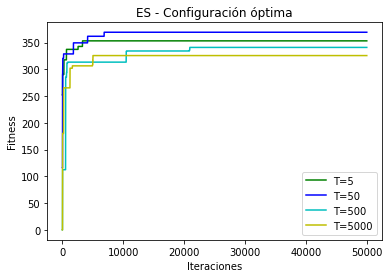

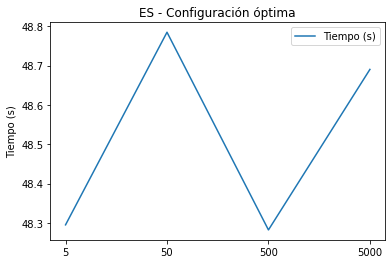

In [11]:
# Mejor fitness por iteración

value = None
colorIdx=0
for testIdx, h in enumerate(histories):

  x = range(len(h))
  y = [d['best']['results']['score'] for d in h]

  if value != X[testIdx]:
    value = X[testIdx]
    colorIdx = Next(colors,colorIdx)
    plt.plot(x, y, label=f'T={X[testIdx]}', color=colors[colorIdx])
  else:
    plt.plot(x, y, color=colors[colorIdx])

plt.xlabel("Iteraciones")
plt.ylabel("Fitness")
plt.title("ES - Configuración óptima")
plt.legend()
plt.show()

# time spent

x = range(len(X))
y = times_spent
plt.plot(x, y, label="Tiempo (s)")
plt.xticks(x, X)
plt.ylabel("Tiempo (s)")
plt.title("ES - Configuración óptima")
plt.legend()
plt.show()